<a href="https://colab.research.google.com/github/rachit2005/Transformer/blob/main/transformer(attention_is_all_you_need).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

dmodel = 512 --> in paper , it represents the size of the embedding vector of each word

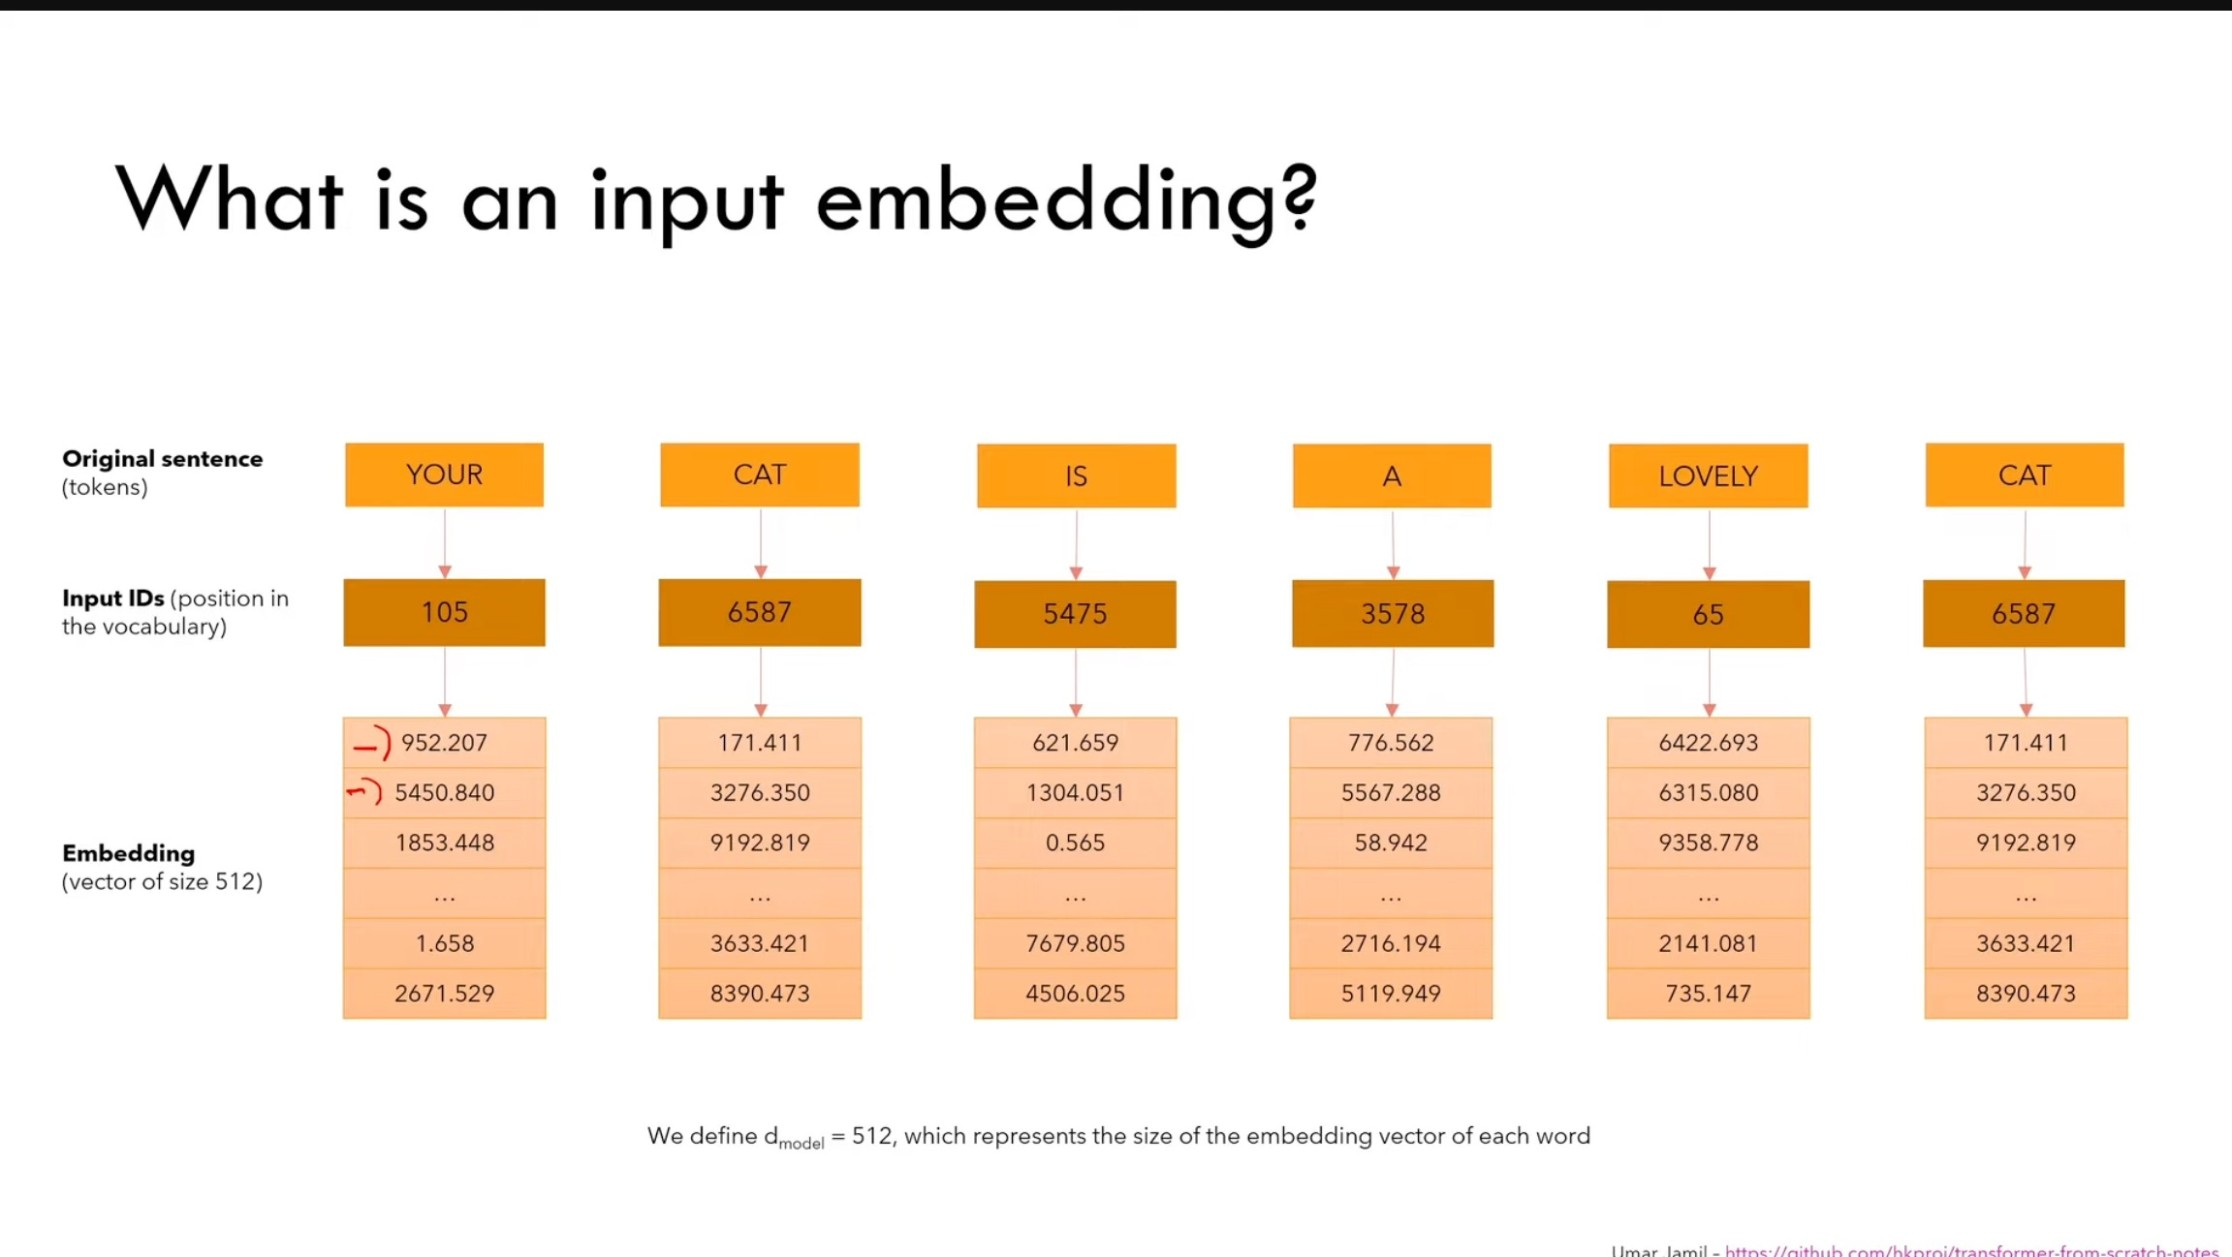

Input Embedding --> the process of converting input text (words or subwords) into numerical vectors, capturing their semantic meaning

In [1]:
import torch
from torch import nn
import math

class InputEmbedding(nn.Module):
  def __init__(self, d_model:int, vocab_size:int):
    super().__init__()
    self.d_model = d_model
    self.vocab_size = vocab_size
    self.embedding = nn.Embedding(vocab_size, d_model)

  def forward(self, x):
    return self.embedding(x) * math.sqrt(self.d_model) # given in paper under Embedding and Softmax title

Positional Embedding --> a technique used to inject information about the position of words in a sequence into the model's architecture

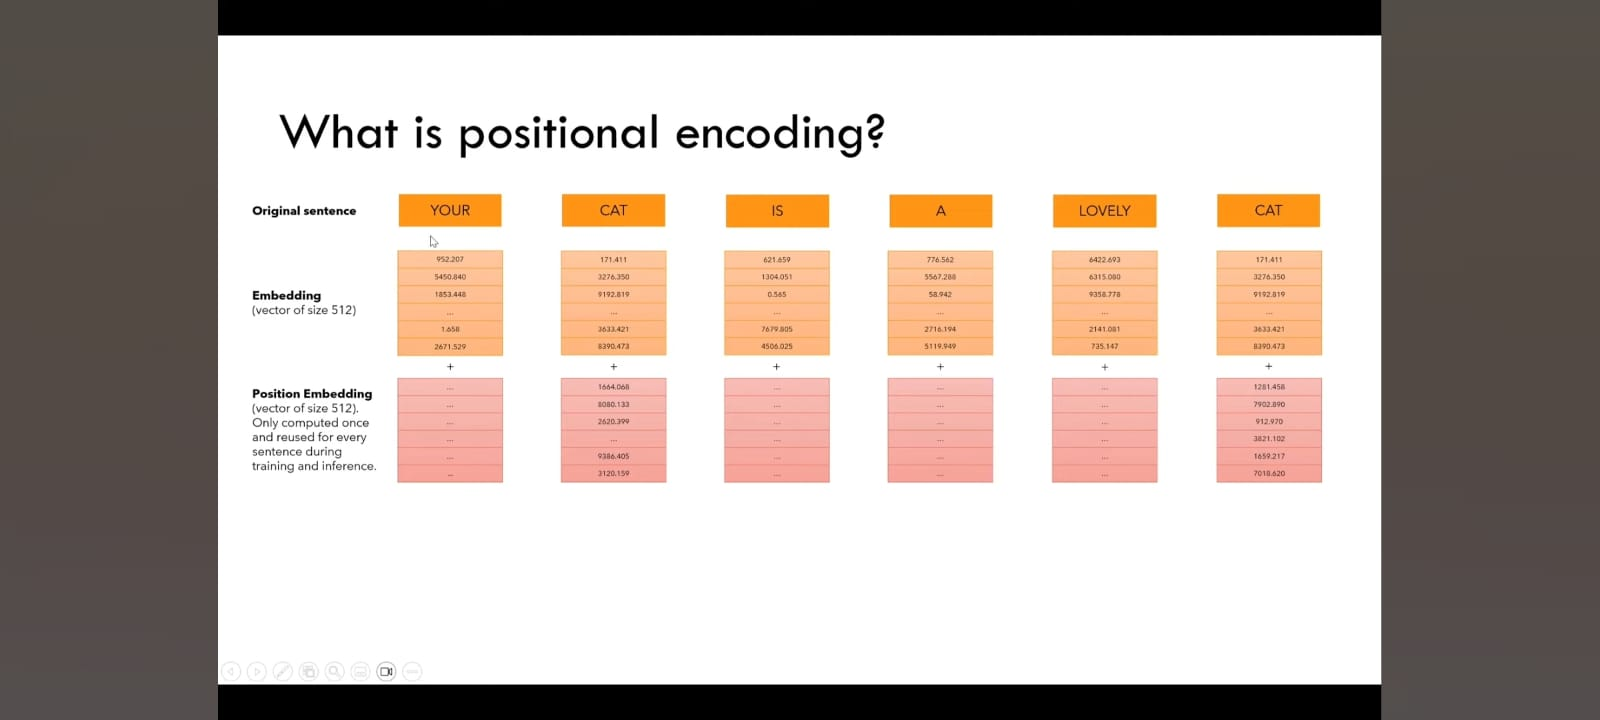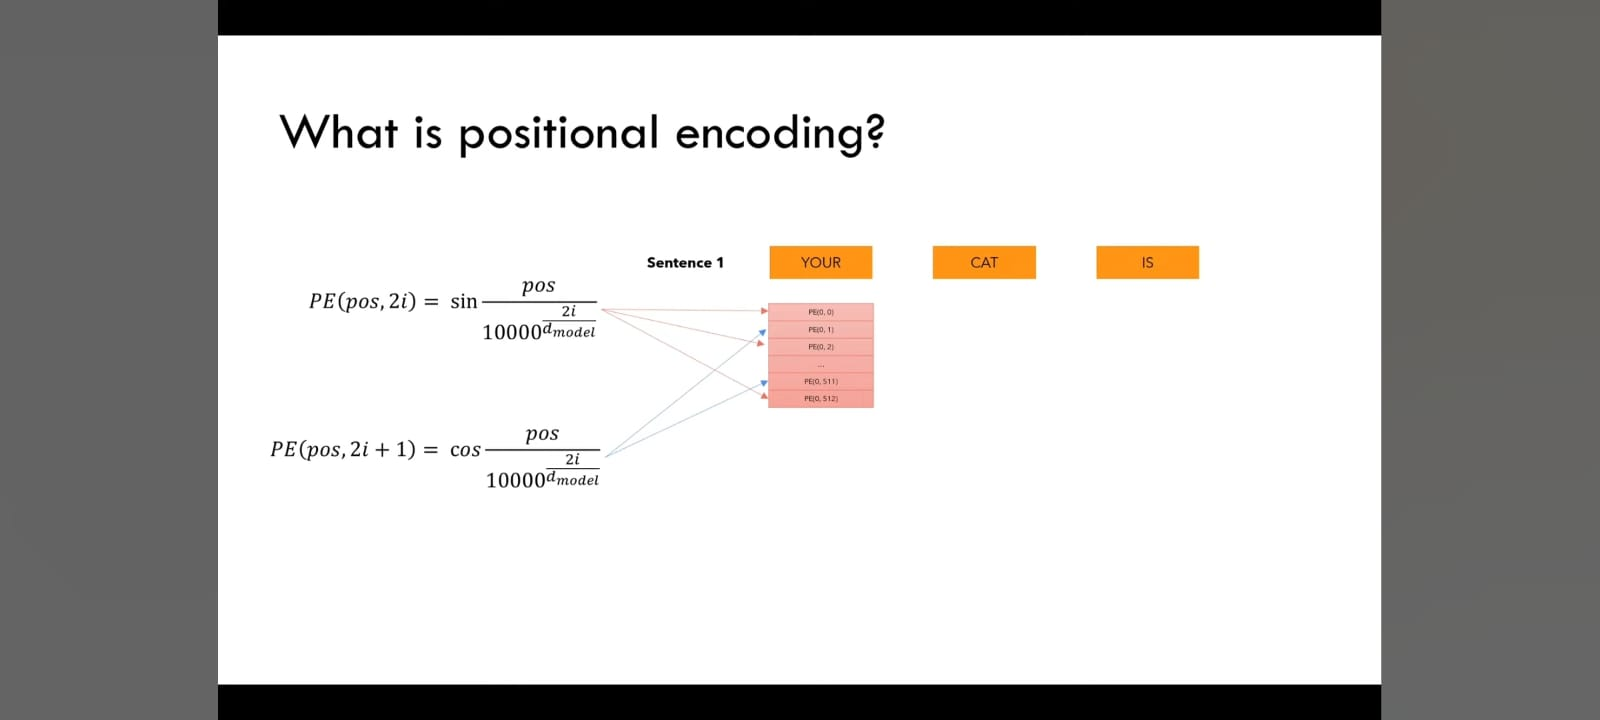

In [2]:
class PositionalEncoding(nn.Module):
  def __init__(self , d_model,seq_length , dropout):
    super().__init__()
    self.d_model = d_model
    self.seq_length = seq_length
    self.dropout = nn.Dropout(p=dropout)

    # create a matrix of shape (seq_length , d_model)
    pe = torch.zeros(seq_length ,d_model)
    # create a vector which represent the position of the word in the sentence
    position = torch.arange(0,seq_length, dtype=torch.float).unsqueeze(1) # --> shape : [seq_length , 1]
    div_term = torch.exp(torch.arange(0 , d_model , 2).float()*(-math.log(10000)/d_model)) # --> shape : [d_model/2]
    # apply the sin to even pos and cos to odd pos
    pe[:,0::2] = torch.sin(position * div_term) # --> all the columns with rows from 0 with step of 2
    pe[:,1::2] = torch.cos(position * div_term)

    # now we add the batch dimension to apply to whole sentences
    pe = pe.unsqueeze(0) # --> shape: [1,seq_length , d_model]
    self.register_buffer('pe' , pe)

  def forward(self , x):
    # x.shape --> [batch_size, seq_length, d_model]
    x = x + (self.pe[: , :x.shape[1] , :]).requires_grad_(False)
    return self.dropout(x)


Layer Normalization --> normalization technique like batch normalization

In [3]:
class LayerNormalization(nn.Module):
  def __init__(self , epsilon:float = 10**-6):
    super().__init__()
    self.eps = epsilon
    # nn.Parameter --> it is a special tensor that tells the model that it is a learnable parameter
    self.gamma = nn.Parameter(torch.ones(1))
    self.beta = nn.Parameter(torch.zeros(1))

  def forward(self , x):
    mean = x.mean(dim=-1 , keepdim=True)
    std = x.std(dim=-1 , keepdim=True)

    gamma = self.gamma.to(x.device)
    beta = self.beta.to(x.device)

    return gamma*(x-mean)/(std + self.eps) + beta

Feed Forward Layer --> This consists of two linear transformations(W1 , W2 , b1 , b2) with a ReLU activation(max-function) in between.

FFN(x) = max(0xW1 +b1)W2 +b2

and the first layer in from d_model to d_ff and then the other one is from d_ff to d_model

In [4]:
class FeedForwardLayer(nn.Module):
  def __init__(self , d_model , d_ff , dropout):
    super().__init__()
    self.feed_forward = nn.Sequential(
        nn.Linear(d_model , d_ff), # [batch , seq_length , d_model] --> [batch , seq_length , d_ff]
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(d_ff , d_model),# [batch , seq_length , d_ff] --> [batch , seq_length , d_model]
    )

  def forward(self , x):
    return self.feed_forward(x)

Multi-Head-Attention --> a mechanism that enhances the original attention mechanism by running it multiple times in parallel, each with its own learnable parameters.

please watch "https://www.youtube.com/watch?v=bCz4OMemCcA"

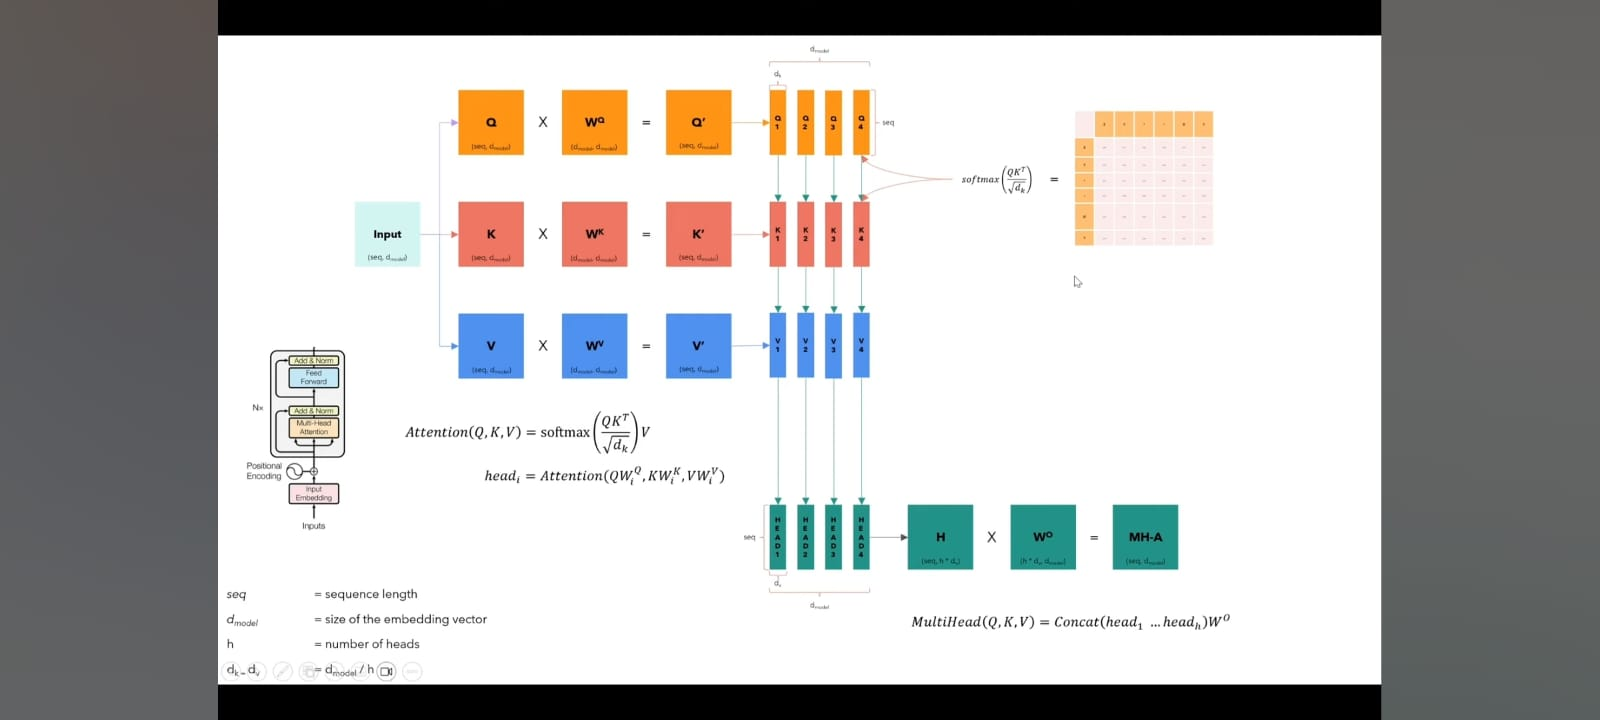

In [23]:
class MultiheadAttention(nn.Module):
  def __init__(self , d_model , h , dropout):
    super().__init__()
    self.d_model = d_model
    self.num_heads = h
    self.d_k = d_model // h
    self.dropout = nn.Dropout(p=dropout)
    assert d_model%h == 0

    self.w_q = nn.Linear(d_model , d_model)
    self.w_k = nn.Linear(d_model , d_model)
    self.w_v = nn.Linear(d_model , d_model)

    self.w_o = nn.Linear(h*self.d_k, d_model) # h*d_k == d_model

    self.dropout = nn.Dropout(p=dropout)

  @staticmethod
  def attention(query , key , value ,mask , dropout):
    d_k = query.shape[-1]
    # remember --> key shape: [batch , num_heads , seq_length , d_k] , after transpose --> [batch , num_heads , d_k ,seq_length]
    attention_scores = (query @ key.transpose(-2 , -1))//d_k**(0.5) # --> [batch , num_heads , seq_length,seq_length]
    if mask is not None:
      attention_scores.masked_fill_(mask==0 , -1e9)
    attention_scores = attention_scores.softmax(dim=-1)

    if dropout is not None:
      attention_scores = dropout(attention_scores)

    return attention_scores @ value , attention_scores # --> shapes -> [batch , num_heads , seq_length , d_k] , [batch , num_heads , seq_length,seq_length]

  def forward(self, q,k,v, mask):
    # q.shape --> [batch , seq_length , d_model]
    query = self.w_q(q) # --> [batch , seq_length , d_model]
    key = self.w_k(k) # --> [batch , seq_length , d_model]
    value = self.w_v(v) # --> [batch , seq_length , d_model]

    # [batch , seq_length , d_model] --> [batch , seq_length , num_heads , d_k] --> [batch , num_heads , seq_length , d_k]
    query = query.view(query.shape[0] , query.shape[1] , self.num_heads , self.d_k).transpose(1,2)
    key = key.view(key.shape[0] , key.shape[1] , self.num_heads , self.d_k).transpose(1,2)
    value = value.view(value.shape[0] , value.shape[1] , self.num_heads , self.d_k).transpose(1,2)

    x , attention_scores = MultiheadAttention.attention(query , key , value , mask , self.dropout)

    # [batch , num_heads , seq_length , d_k] --> [batch , seq_length , num_heads , d_k] --> [batch , seq_length , d_model]
    x = x.transpose(1,2).contiguous().view(x.shape[0] , -1 , self.d_model)

    return self.w_o(x) # shape --> [batch , seq_length , d_model]

In [6]:
class ResidualConnection(nn.Module):
  def __init__(self , dropout):
    super().__init__()
    self.dropout = nn.Dropout(dropout)
    self.norm = LayerNormalization()

  def forward(self, x , sublayer):
    # sublayer is the prev layer
    return x + self.dropout(sublayer(self.norm(x)))

# Encoder

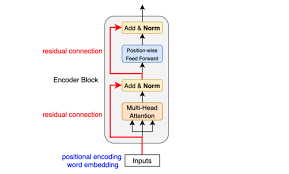

In a Transformer architecture, the encoder's key and value tensors are used by the decoder

In [7]:
class EncoderBlock(nn.Module):
  def __init__(self ,self_attention_block:MultiheadAttention , feed_forward_block:FeedForwardLayer, dropout):
    super().__init__()
    self.self_attention_block = self_attention_block
    self.feed_forward_block = feed_forward_block
    self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(2)])

  def forward(self, x, mask):
    # first we do the self attention --> making the words intereact with each other in the same sentences
    x = self.residual_connections[0](x , lambda x: self.self_attention_block(x,x,x,mask))
    x = self.residual_connections[1](x , self.feed_forward_block)

    return x # now this will go to the decoder as key and value pair

In [8]:
class Encoder(nn.Module):
  def __init__(self , layers:nn.Module):
    super().__init__()
    self.layers = layers
    self.norm = LayerNormalization()

  def forward(self , x ,mask):
    for layer in self.layers:
      x = layer(x , mask)

    return self.norm(x)

# Decoder

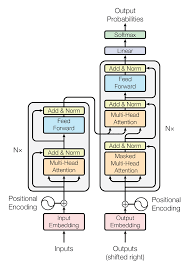

In [9]:
class DecoderBlock(nn.Module):
  def __init__(self , self_attention_block:MultiheadAttention , cross_attention_block:MultiheadAttention , feed_forward_block:FeedForwardLayer, dropout):
    super().__init__()
    self.self_attention_block = self_attention_block
    self.cross_attention_block = cross_attention_block
    self.feed_forward_block = feed_forward_block
    self.residual_connections = [ResidualConnection(dropout) for _ in range(3)]

  def forward(self , x , encoder_output , encoder_mask,decoder_mask):
    x = self.residual_connections[0](x , lambda x: self.self_attention_block(x,x,x,decoder_mask))
    x = self.residual_connections[1](x , lambda x:self.cross_attention_block(x,encoder_output,encoder_output,encoder_mask)) # in this query will come from the masked multi-head-attention and the key and value will come from the encoder block output
    x = self.residual_connections[2](x , self.feed_forward_block)

    return x

In [10]:
class Decoder(nn.Module):
  def __init__(self , layers:nn.Module):
    super().__init__()
    self.layers = layers
    self.norm = LayerNormalization()

  def forward(self , x , encoder_output , encoder_mask , decoder_mask):
    for layer in self.layers:
      x = layer(x , encoder_output , encoder_mask , decoder_mask)

    return self.norm(x)

# we expect the output form decoder to be --> [batch , seq_length , d_model]

In [11]:
# now we want to map these words into the vocabulary
class ProjectionLayer(nn.Module):
  def __init__(self , d_model , vocab_size):
    super().__init__()
    self.proj = nn.Linear(d_model , vocab_size)

  def forward(self , x):
    # x.shape --> [batch , seq_length , d_model]
    return torch.log_softmax(self.proj(x) ,dim=-1) # --> [batch , seq_length , vocab_size]

# Transformer Block  -->

In [12]:
class Transformer(nn.Module):
  def __init__(self , encoder:Encoder , decoder:Decoder , src_emb:InputEmbedding , trg_emb:InputEmbedding , srcpos:PositionalEncoding , trgpos:PositionalEncoding , projection_layer:ProjectionLayer):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.src_emb = src_emb
    self.trg_emb = trg_emb
    self.srcpos = srcpos
    self.trgpos = trgpos
    self.projection_layer = projection_layer

  def encode(self , src , src_mask):
    src = self.srcpos(self.src_emb(src))
    return self.encoder(src , src_mask)

  def decode(self , trg , encoder_output , src_mask , trg_mask):
    trg = self.trgpos(self.trg_emb(trg))
    return self.decode(trg , encoder_output , src_mask , trg_mask)

  def projection_layer(self , x):
    return self.projection_layer(x)

In [13]:
def build_transformer(src_vocab_size , trg_vocab_size , src_seq_length , trg_seq_length , d_model , h , dropout , N , d_ff):
  # create embedding layer for source and target
  src_embed = InputEmbedding(src_vocab_size , d_model)
  trg_embed = InputEmbedding(trg_vocab_size , d_model)

  # create positional embedding layer
  src_pos = PositionalEncoding(d_model , src_seq_length , dropout)
  trg_pos = PositionalEncoding(d_model , trg_seq_length , dropout)

  # create encoder block
  encoder_blocks = []
  for _ in range(N):
    encoder_self_attention_block = MultiheadAttention(d_model , h , dropout)
    feed_forward_block = FeedForwardLayer(d_model , d_ff , dropout)
    encoder_block = EncoderBlock(encoder_self_attention_block , feed_forward_block , dropout)
    encoder_blocks.append(encoder_block)

  # create decoder block
  decoder_blocks = []
  for _ in range(N):
    decoder_self_attention_block = MultiheadAttention(d_model , h , dropout)
    decoder_cross_attention_block = MultiheadAttention(d_model , h , dropout)
    feed_forward_block = FeedForwardLayer(d_model , d_ff , dropout)
    decoder_block = DecoderBlock(decoder_self_attention_block , decoder_cross_attention_block , feed_forward_block , dropout)
    decoder_blocks.append(decoder_block)

  # create the encoder and decoder
  encoder = Encoder(encoder_blocks)
  decoder = Decoder(decoder_blocks)

  # create projection layer
  projection_layer = nn.Linear(d_model , trg_vocab_size)

  # create transformer
  transformer = Transformer(encoder , decoder , src_embed , trg_embed , src_pos , trg_pos , projection_layer)

  # initialize parameters using xavier_uniform_
  for p in transformer.parameters():
    if p.dim() > 1:
      nn.init.xavier_uniform_(p)

  return transformer

In [14]:
!wget -nc https://downloads.tatoeba.org/exports/sentences.tar.bz2
!wget -nc https://downloads.tatoeba.org/exports/links.tar.bz2
!tar -xf sentences.tar.bz2
!tar -xf links.tar.bz2


File ‘sentences.tar.bz2’ already there; not retrieving.

File ‘links.tar.bz2’ already there; not retrieving.



In [15]:
import pandas as pd

df = pd.read_csv("sentences.csv", sep="\t", header=None, names=["id", "lang", "text"])
# print(df.head())

df_eng = df[df['lang']=='eng']
df_hindi = df[df['lang'] == 'hin']

# print(df_eng.head())
# print(df_hindi.head())

links = pd.read_csv('links.csv' , sep='\t' , header=None , names=["src" , "tgt"]) # loads the links bettwen the target
# print(links.head())

# Merge to get aligned pairs
merged = links.merge(df_eng, left_on="src", right_on="id").merge(df_hindi, left_on="tgt", right_on="id", suffixes=('_en', '_hi'))
print(merged.head())

en_sentences = merged['text_en'].tolist()
hi_sentences = merged['text_hi'].tolist()

print(f"Found {len(en_sentences)} English–Hindi sentence pairs")

    src      tgt  id_en lang_en                     text_en    id_hi lang_hi  \
0  1277  3792910   1277     eng      I have to go to sleep.  3792910     hin   
1  1282   485968   1282     eng          Muiriel is 20 now.   485968     hin   
2  1282  2060319   1282     eng          Muiriel is 20 now.  2060319     hin   
3  1283   451291   1283     eng  The password is "Muiriel".   451291     hin   
4  1283   451292   1283     eng  The password is "Muiriel".   451292     hin   

                            text_hi  
0                     मुझे सोना है।  
1  म्यूरियल अब बीस साल की हो गई है।  
2        म्यूरियल अब बीस साल की है।  
3              कूटशब्द "Muriel" है।  
4              पासवर्ड "Muriel" है।  
Found 13182 English–Hindi sentence pairs


In [16]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace
from pathlib import Path


# converting the lines to txt file
with open("eng.txt" , "w") as f:
  for line in en_sentences:
    f.write(line.strip() + "\n")

with open("hindi.txt" , "w") as f:
  for line in hi_sentences:
    f.write(line.strip() + "\n")

In [29]:
def train_tokenizer(file_path:Path , vocab_size:int , output_path:Path):
  tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
  tokenizer.pre_tokenizer = Whitespace()
  trainer = WordLevelTrainer(vocab_size=vocab_size , special_tokens=["[PAD]" , "[SOS]" , "[EOS]" , "[UNK]"] , min_frequency=2)
  tokenizer.train([file_path] , trainer)
  tokenizer.save(output_path)

train_tokenizer("eng.txt" , 8000 , "en-tokenize.json")
train_tokenizer("hindi.txt" , 8000 , "hindi-tokenize.json")

eng_tokenizer = Tokenizer.from_file("en-tokenize.json")
hindi_tokenizer = Tokenizer.from_file("hindi-tokenize.json")

VOCAB_SIZE_ENG = eng_tokenizer.get_vocab_size()     # 5912
VOCAB_SIZE_HINDI = hindi_tokenizer.get_vocab_size() # 7070

creating a dataset

In [18]:
seq_length_for_example = 5

a = torch.triu(torch.ones((1,seq_length_for_example,seq_length_for_example)) , diagonal=1)
print(a)
print(a.shape)

# to create a proper mask for decoder
print((a == 0).int())


tensor([[[0., 1., 1., 1., 1.],
         [0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]])
torch.Size([1, 5, 5])
tensor([[[1, 0, 0, 0, 0],
         [1, 1, 0, 0, 0],
         [1, 1, 1, 0, 0],
         [1, 1, 1, 1, 0],
         [1, 1, 1, 1, 1]]], dtype=torch.int32)


In [19]:
import torch
device = torch.device("cpu")
device

device(type='cpu')

In [27]:
from torch.utils.data import Dataset, DataLoader
import torch

ds = [
    {"translation": {"en": en, "hi": hi}} for en, hi in zip(en_sentences, hi_sentences)
]

def casual_mask(size):
    mask = torch.triu(torch.ones((1, size, size)), diagonal=1).type(torch.int)
    return mask == 0

class Eng_Hindi_Dataset(Dataset):
    def __init__(self, ds, device, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, seq_length):
        super().__init__()
        self.device = device
        self.ds = ds
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang
        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt
        self.seq_length = seq_length

        # Get special token IDs and validate them
        self.sos_token_src = self._get_token_id(tokenizer_src, "[SOS]")
        self.eos_token_src = self._get_token_id(tokenizer_src, "[EOS]")
        self.pad_token_src = self._get_token_id(tokenizer_src, "[PAD]")

        self.sos_token_tgt = self._get_token_id(tokenizer_tgt, "[SOS]")
        self.eos_token_tgt = self._get_token_id(tokenizer_tgt, "[EOS]")
        self.pad_token_tgt = self._get_token_id(tokenizer_tgt, "[PAD]")

        # Store vocab sizes for validation
        self.src_vocab_size = tokenizer_src.get_vocab_size()
        self.tgt_vocab_size = tokenizer_tgt.get_vocab_size()

    def _get_token_id(self, tokenizer, token):
        """Helper method to get token ID with error handling"""
        token_id = tokenizer.token_to_id(token)
        if token_id is None:
            raise ValueError(f"Token '{token}' not found in tokenizer vocabulary")
        return token_id

    def _validate_token_ids(self, token_ids, vocab_size, tokenizer_name):
        """Validate that all token IDs are within vocabulary range"""
        max_id = max(token_ids) if token_ids else 0
        if max_id >= vocab_size:
            raise ValueError(f"Token ID {max_id} exceeds {tokenizer_name} vocabulary size {vocab_size}")

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, index):
        src_target_pair = self.ds[index]

        src_text = src_target_pair["translation"][self.src_lang]
        tgt_text = src_target_pair["translation"][self.tgt_lang]

        # Encode texts
        enc_input_tokens = self.tokenizer_src.encode(src_text).ids
        dec_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids

        # Validate token IDs are within vocabulary range
        self._validate_token_ids(enc_input_tokens, self.src_vocab_size, "source")
        self._validate_token_ids(dec_input_tokens, self.tgt_vocab_size, "target")

        # Calculate padding
        enc_num_pad = self.seq_length - len(enc_input_tokens) - 2  # -2 for SOS and EOS
        dec_num_pad = self.seq_length - len(dec_input_tokens) - 1  # -1 for EOS

        if enc_num_pad < 0 or dec_num_pad < 0:
            raise ValueError(f"Sentence is too long. Source: {len(enc_input_tokens)}, Target: {len(dec_input_tokens)}, Max length: {self.seq_length}")

        # Create encoder input: [SOS] + tokens + [EOS] + padding
        encoder_input = torch.cat([
            torch.tensor([self.sos_token_src], dtype=torch.long),
            torch.tensor(enc_input_tokens, dtype=torch.long),
            torch.tensor([self.eos_token_src], dtype=torch.long),
            torch.tensor([self.pad_token_src] * enc_num_pad, dtype=torch.long),
        ])

        # Create decoder input: [SOS] + tokens + padding
        decoder_input = torch.cat([
            torch.tensor([self.sos_token_tgt], dtype=torch.long),
            torch.tensor(dec_input_tokens, dtype=torch.long),
            torch.tensor([self.pad_token_tgt] * dec_num_pad, dtype=torch.long),
        ])

        # Create labels: tokens + [EOS] + padding
        label = torch.cat([
            torch.tensor(dec_input_tokens, dtype=torch.long),
            torch.tensor([self.eos_token_tgt], dtype=torch.long),
            torch.tensor([self.pad_token_tgt] * dec_num_pad, dtype=torch.long),
        ])

        # Verify all tensors have correct length
        assert encoder_input.size(0) == self.seq_length, f"Encoder input size: {encoder_input.size(0)}, expected: {self.seq_length}"
        assert decoder_input.size(0) == self.seq_length, f"Decoder input size: {decoder_input.size(0)}, expected: {self.seq_length}"
        assert label.size(0) == self.seq_length, f"Label size: {label.size(0)}, expected: {self.seq_length}"

        # Create masks
        encoder_mask = (encoder_input != self.pad_token_src).unsqueeze(0).unsqueeze(0).int()

        # Decoder mask: padding mask AND causal mask
        decoder_padding_mask = (decoder_input != self.pad_token_tgt).unsqueeze(0).int()
        decoder_causal_mask = casual_mask(decoder_input.size(0)).int()
        decoder_mask = decoder_padding_mask & decoder_causal_mask

        return {
            "encoder_input": encoder_input,
            "decoder_input": decoder_input,
            "label": label,
            "encoder_mask": encoder_mask.to(self.device),
            "decoder_mask": decoder_mask.to(self.device),
            "src_text": src_text,
            "tgt_text": tgt_text,
        }


# Configuration
BATCH_SIZE = 32
SEQ_LENGTH = 350

# Create dataset
dataset = Eng_Hindi_Dataset(ds, device, eng_tokenizer, hindi_tokenizer, "en", "hi", SEQ_LENGTH)

# Split dataset
n = int(0.8 * len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [n, len(dataset) - n])

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Test the dataloader
print("Testing dataloader...")
for batch in train_dataloader:
    print(f"Encoder input shape: {batch['encoder_input'].shape}")  # torch.Size([32, 350])
    print(f"Decoder input shape: {batch['decoder_input'].shape}")  # torch.Size([32, 350])
    print(f"Label shape: {batch['label'].shape}")                  # torch.Size([32, 350])
    print(f"Encoder mask shape: {batch['encoder_mask'].shape}")    # torch.Size([32, 1, 1, 350])
    print(f"Decoder mask shape: {batch['decoder_mask'].shape}")    # torch.Size([32, 1, 350, 350])

    # Print some sample data for verification
    print(f"Sample source text: {batch['src_text'][0]}")
    print(f"Sample target text: {batch['tgt_text'][0]}")

    # Print token ID ranges for debugging
    print(f"Encoder input token range: {batch['encoder_input'].min().item()} - {batch['encoder_input'].max().item()}")
    print(f"Decoder input token range: {batch['decoder_input'].min().item()} - {batch['decoder_input'].max().item()}")

    break

print("Dataloader test completed successfully!")

Testing dataloader...
Encoder input shape: torch.Size([32, 350])
Decoder input shape: torch.Size([32, 350])
Label shape: torch.Size([32, 350])
Encoder mask shape: torch.Size([32, 1, 1, 350])
Decoder mask shape: torch.Size([32, 1, 350, 350])
Sample source text: He was sleeping under the tree.
Sample target text: वह पेड़ के नीचे सो रहा था।
Encoder input token range: 0 - 5482
Decoder input token range: 0 - 6083
Dataloader test completed successfully!


Training the transformer

In [21]:
!pip install --upgrade sympy

In [31]:
VOCAB_SIZE_ENG = 5912  # eng_tokenizer.get_vocab_size()
VOCAB_SIZE_HINDI = 7070 # hindi_tokenizer.get_vocab_size()
BATCH_SIZE = 32
NUM_EPOCHS = 20
LR = 10**-4
D_model = 512
D_ff = 2048
H = 8 # no of heads
N = 6 # no of layers
DROPOUT = 0.1

losses = []

model = build_transformer(VOCAB_SIZE_ENG , VOCAB_SIZE_HINDI  , SEQ_LENGTH , SEQ_LENGTH , D_model , H , DROPOUT , N , D_ff).to(device)
optimizer = torch.optim.Adam(model.parameters() , LR)
criterion = nn.CrossEntropyLoss(ignore_index=hindi_tokenizer.token_to_id("[PAD]") , label_smoothing=0.1).to(device)

from tqdm.auto import tqdm

for epoch in tqdm(range(NUM_EPOCHS)):
  model.train()
  for batch in train_dataloader:
    print("in batch loop")
    encoder_input = batch["encoder_input"].long().to(device)  # Convert to Long type
    decoder_input = batch["decoder_input"].long().to(device)  # Convert to Long type
    label = batch["label"].long().to(device)  # Convert to Long type
    encoder_mask = batch["encoder_mask"].to(device)
    decoder_mask = batch["decoder_mask"].to(device)

    encoder_output = model.encode(encoder_input , encoder_mask)
    decoder_output = model.decode(decoder_input , encoder_output , encoder_mask , decoder_mask)
    proj_output = model.projection_layer(decoder_output)

    print(proj_output.shape , label.shape)
    break


  0%|          | 0/20 [00:00<?, ?it/s]

in batch loop


IndexError: index out of range in self